In [70]:
'''
This is where everything ends up from the creation notebook
'''

path_saves = './realistic', './unrealistic'


levels = ['low', 'medium', 'high']

In [71]:
import matplotlib.pyplot as plt

# Initialize global storage
global_storage = {
    'occ_lvl': [],
    'confidence': [],
    'accuracy_iou': [],
    'accuracy_label': []
}

# Validated occllusion levels 
def validate_occlusion_level(occ_lvl):
    valid_levels = {"low", "medium", "high"}
    if occ_lvl.lower() not in valid_levels:
        raise ValueError(f"Invalid occlusion level '{occ_lvl}'. Expected one of {valid_levels}.")
    return occ_lvl.lower()

# Example function to add data
def store_metrics(occ_lvl, confidence, accuracy_iou, accuracy_label):
    """
    Stores the provided metrics in global storage after validation.
    
    Parameters:
        occ_lvl (str): Occlusion level ('low', 'medium', 'high').
        confidence (float): Confidence value.
        accuracy_iou (float): Intersection over Union accuracy.
        accuracy_label (float): Label truth accuracy.
    """
    validated_level = validate_occlusion_level(occ_lvl)
    global_storage['occ_lvl'].append(validated_level)
    global_storage['confidence'].append(confidence)
    global_storage['accuracy_iou'].append(accuracy_iou)
    global_storage['accuracy_label'].append(accuracy_label)

# Function to aggregate metrics by occlusion level
def aggregate_metrics():
    levels = ["low", "medium", "high"]
    aggregated = {level: {"confidence": [], "accuracy_iou": [], "accuracy_label": []} for level in levels}

    for occ_lvl, conf, iou, label in zip(global_storage['occ_lvl'], global_storage['confidence'], global_storage['accuracy_iou'], global_storage['accuracy_label']):
        aggregated[occ_lvl]["confidence"].append(conf)
        aggregated[occ_lvl]["accuracy_iou"].append(iou)
        aggregated[occ_lvl]["accuracy_label"].append(label)
    
    # Calculate averages
    averages = {
        level: {
            "confidence": np.mean(aggregated[level]["confidence"]) if aggregated[level]["confidence"] else 0,
            "accuracy_iou": np.mean(aggregated[level]["accuracy_iou"]) if aggregated[level]["accuracy_iou"] else 0,
            "accuracy_label": np.mean(aggregated[level]["accuracy_label"]) if aggregated[level]["accuracy_label"] else 0
        }
        for level in levels
    }
    return averages

# Function to plot bar graphs
def plot_metrics():
    averages = aggregate_metrics()
    levels = ["low", "medium", "high"]

    # Extract metrics for plotting
    confidence = [averages[level]["confidence"] for level in levels]
    accuracy_iou = [averages[level]["accuracy_iou"] for level in levels]
    accuracy_label = [averages[level]["accuracy_label"] for level in levels]

    x = np.arange(len(levels))  # the label locations
    width = 0.25  # the width of the bars

    plt.figure(figsize=(10, 8))

    # Confidence Bar
    plt.bar(x - width, confidence, width, label='Confidence')
    # Accuracy IoU Bar
    plt.bar(x, accuracy_iou, width, label='Accuracy (IoU)')
    # Accuracy Label Bar
    plt.bar(x + width, accuracy_label, width, label='Accuracy (Label Truth)')

    # Add labels, title, and legend
    plt.xlabel("Occlusion Levels")
    plt.ylabel("Metrics")
    plt.title("Metrics by Occlusion Levels")
    plt.xticks(x, levels)
    plt.legend()

    plt.tight_layout()
    plt.show()

# # Example of adding metrics
# store_metrics(0.1, 0.85, 0.9, 0.88)
# store_metrics(0.2, 0.8, 0.85, 0.86)

# # Plot the graphs
# plot_metrics()


In [72]:
'''
Intersection Over Union
'''
# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by the intersection area
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )

In [73]:
import json

def read_annotation(anno_file):
    with open(anno_file, 'r') as f:
        # Load the JSON data into a Python dictionary

        anno = json.load(f)

        bg_bbox = anno['box']
        occlusion_ratio = anno['ratio']
        occluder_bbox = anno['occluder_box']
        occluder_path = anno['occluder_path']
        bg_img = anno['source']
        cate = anno['cate']

    return bg_bbox, occlusion_ratio, occluder_bbox, occluder_path, bg_img, cate

In [74]:
def process_one_img(processor, model, img_path):
    img = Image.open(img_path)
    
    inputs = processor(images=img, return_tensors="pt")
    outputs = model(**inputs)
    
    target_sizes = torch.tensor([img.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    return results

In [75]:
def get_updated_bb(bg_bbox, bg_w, bg_h, comp_w, comp_h):
    scale_w = comp_w / bg_w
    scale_h = comp_h / bg_h
    
    [x1, y1, x2, y2] = bg_bbox
    
    bb_w = x2 - x1
    bb_h = y2 - y1
    
    x1_new = int(x1 * scale_w)
    y1_new = int(y1 * scale_h)
    x2_new = int(x2 * scale_w)
    y2_new = int(y2 * scale_h)
    
    return [x1_new, y1_new, x2_new, y2_new]

------------------------
Occlusion level: low
------------------------
Mean IoU: 0.790
Total Correct Labels: 80
Avg Correct Labels: 0.930

------------------------
Occlusion level: medium
------------------------
Mean IoU: 0.546
Total Correct Labels: 24
Avg Correct Labels: 0.727

------------------------
Occlusion level: high
------------------------
Mean IoU: 0.559
Total Correct Labels: 6
Avg Correct Labels: 0.545



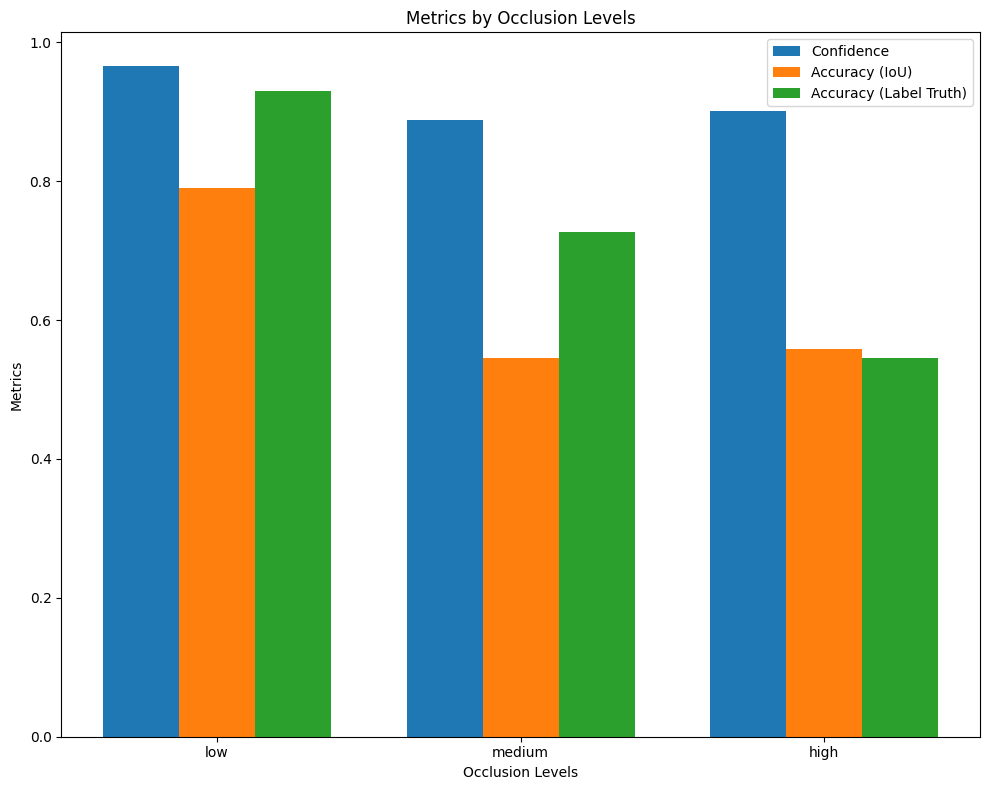

------------------------
Occlusion level: low
------------------------
Mean IoU: 0.876
Total Correct Labels: 86
Avg Correct Labels: 0.977

------------------------
Occlusion level: medium
------------------------
Mean IoU: 0.810
Total Correct Labels: 33
Avg Correct Labels: 0.943

------------------------
Occlusion level: high
------------------------
Mean IoU: 0.747
Total Correct Labels: 9
Avg Correct Labels: 0.750



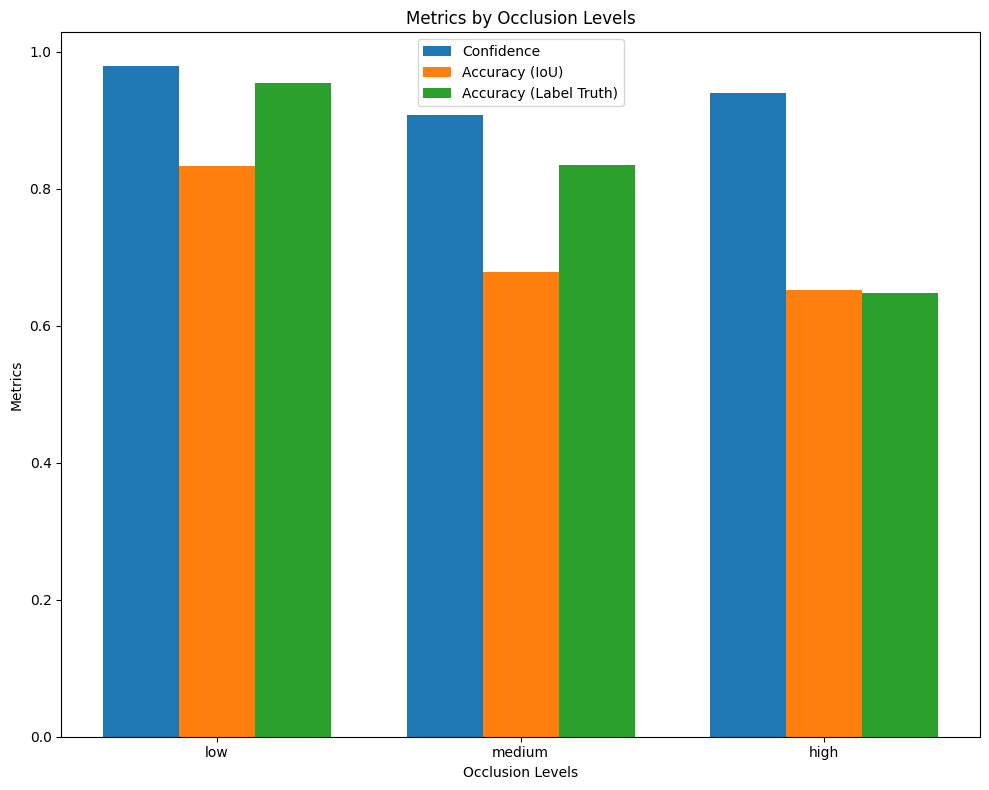

In [76]:
'''
Adapted for the Libcom output
'''

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import os
import cv2
from libcom.utils.process_image import make_image_grid, draw_bbox_on_image
import numpy as np

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
 
for path_save in path_saves:
    save_img_path = path_save + '/images'
    save_anno_path = path_save + '/annotations'
    for level in levels:
        print('------------------------')
        print(f'Occlusion level: {level}')
        print('------------------------')
    
        mean_iou = 0
        mean_confidence = 0
        correct_label_count = 0
        total_predictions = 0
        
        for img_name in os.listdir(os.path.join(save_img_path, level)):
            
            if img_name[0] == '.':
                continue
        
            img_id = img_name.split('.')[0]
            img_path = os.path.join(save_img_path, level, img_name)
        
            results = process_one_img(processor, model, img_path)
        
            box_truth, occlusion_ratio, occluder_bbox, occluder_path, bg_img, label_truth = read_annotation(os.path.join(save_anno_path, level, img_id + '.json'))
            
            bg_img = Image.open(bg_img) 
            bg_w = bg_img.width 
            bg_h = bg_img.height 
            
            comp_img = Image.open(img_path) 
            comp_w = comp_img.width 
            comp_h = comp_img.height 
            
            box_truth_new = get_updated_bb(box_truth, bg_w, bg_h, comp_w, comp_h)
            
            # print(f"Ground truth: {box_truth}")
        
            greatest_iou = 0
            greatest_iou_label = ''
            total_predictions += 1
            greatest_box_predicted = None
            greatest_confidence = 0
        
            # Loops through every bounding box/annotation that the evaluation model produces, 
            for i, (score, label, box) in enumerate(zip(results["scores"], results["labels"], results["boxes"])):
            
                box_predicted = [round(i, 2) for i in box.tolist()]
                label_predicted = model.config.id2label[label.item()]
                confidence = round(score.item(), 3)
        
                box = [round(i, 2) for i in box.tolist()]
                
        
                # Calculate IoU
                iou = bounding_box_intersection_over_union(box_predicted, box_truth_new)
                if iou > greatest_iou:
                    greatest_iou = iou
                    greatest_iou_label = label_predicted
                    greatest_box_predicted = np.array(box_predicted).astype(int)
                    greatest_confidence = confidence
    
                    
            # Comparing predicted label to truth label  
            if greatest_iou_label == label_truth:
                # Tracking this label's bounding box 
                correct_label_count += 1
    
            mean_iou += greatest_iou
            mean_confidence += greatest_confidence
            
            cv2.imwrite(f'./predictions/{img_id}.jpg', grid_img)
            
             # The information that matters, labels should match 
            # print(f"Highest Confidence: {greatest_confidence}")
            # print(f"True label: {label_truth}")
            # print(f"Greatest IoU: {greatest_iou:.3f} with label: {greatest_iou_label}\n")
            
    
     
            # # Final statistics
        
        print(f"Mean IoU: {mean_iou / total_predictions:.3f}")
        print(f"Total Correct Labels: {correct_label_count}")
        print(f"Avg Correct Labels: {correct_label_count / total_predictions:.3f}\n")
        store_metrics(level ,(mean_confidence/ total_predictions), (mean_iou / total_predictions), (correct_label_count / total_predictions))
    
    plot_metrics()